# Titanic Spaceship

## Introduce the problem

A Spaceship collided with a spacetime anomaly hidden within a dust cloud near the Andromeda Galaxy, transporting almost half of the passengers as a result. Our task is to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system

## Obtain the Data

For this task, the data is already sourced, and formatted. A summary of the data is below

* **Train.csv** - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
  *  **PassengerId** - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
  * **HomePlanet** - The planet the passenger departed from, typically their planet of permanent residence.
  * **CryoSleep** - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
  * **Cabin** - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
  * **Destination** - The planet the passenger will be debarking to.
  * **Age** - The age of the passenger.
  * **VIP** - Whether the passenger has paid for special VIP service during the voyage.
  * **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck** - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
  * **Name** - The first and last names of the passenger.
  * **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
  

* **Test.csv** - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
* **Sample_submission.csv** - A submission file in the correct format.
  * **PassengerId** - Id for each passenger in the test set.
  * **Transported** - The target. For each passenger, predict either True or False.



In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Import Data
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

In [3]:
#Overview of the train data
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


## Analyse Data

In [4]:
# The deck and side are useful pieces of information that can be extracted from the Cabin column
train[["Deck", "Number", "Side"]] = train["Cabin"].str.split("/", expand=True)
test[["Deck", "Number", "Side"]] = test["Cabin"].str.split("/", expand=True)

#All these columns provide unique data, so will not aid in analysis
train = train.drop(['PassengerId', 'Name', 'Cabin', 'Number'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Cabin', 'Number'], axis=1)

In [5]:
#Overview of the train data
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,B,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,F,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,A,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,A,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,F,S


In [6]:
train["Side"].unique()

array(['P', 'S', nan], dtype=object)

In [7]:
# Outline of missing data for test and train
display(train.isna().sum())
display(test.isna().sum())

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Deck            199
Side            199
dtype: int64

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Deck            100
Side            100
dtype: int64

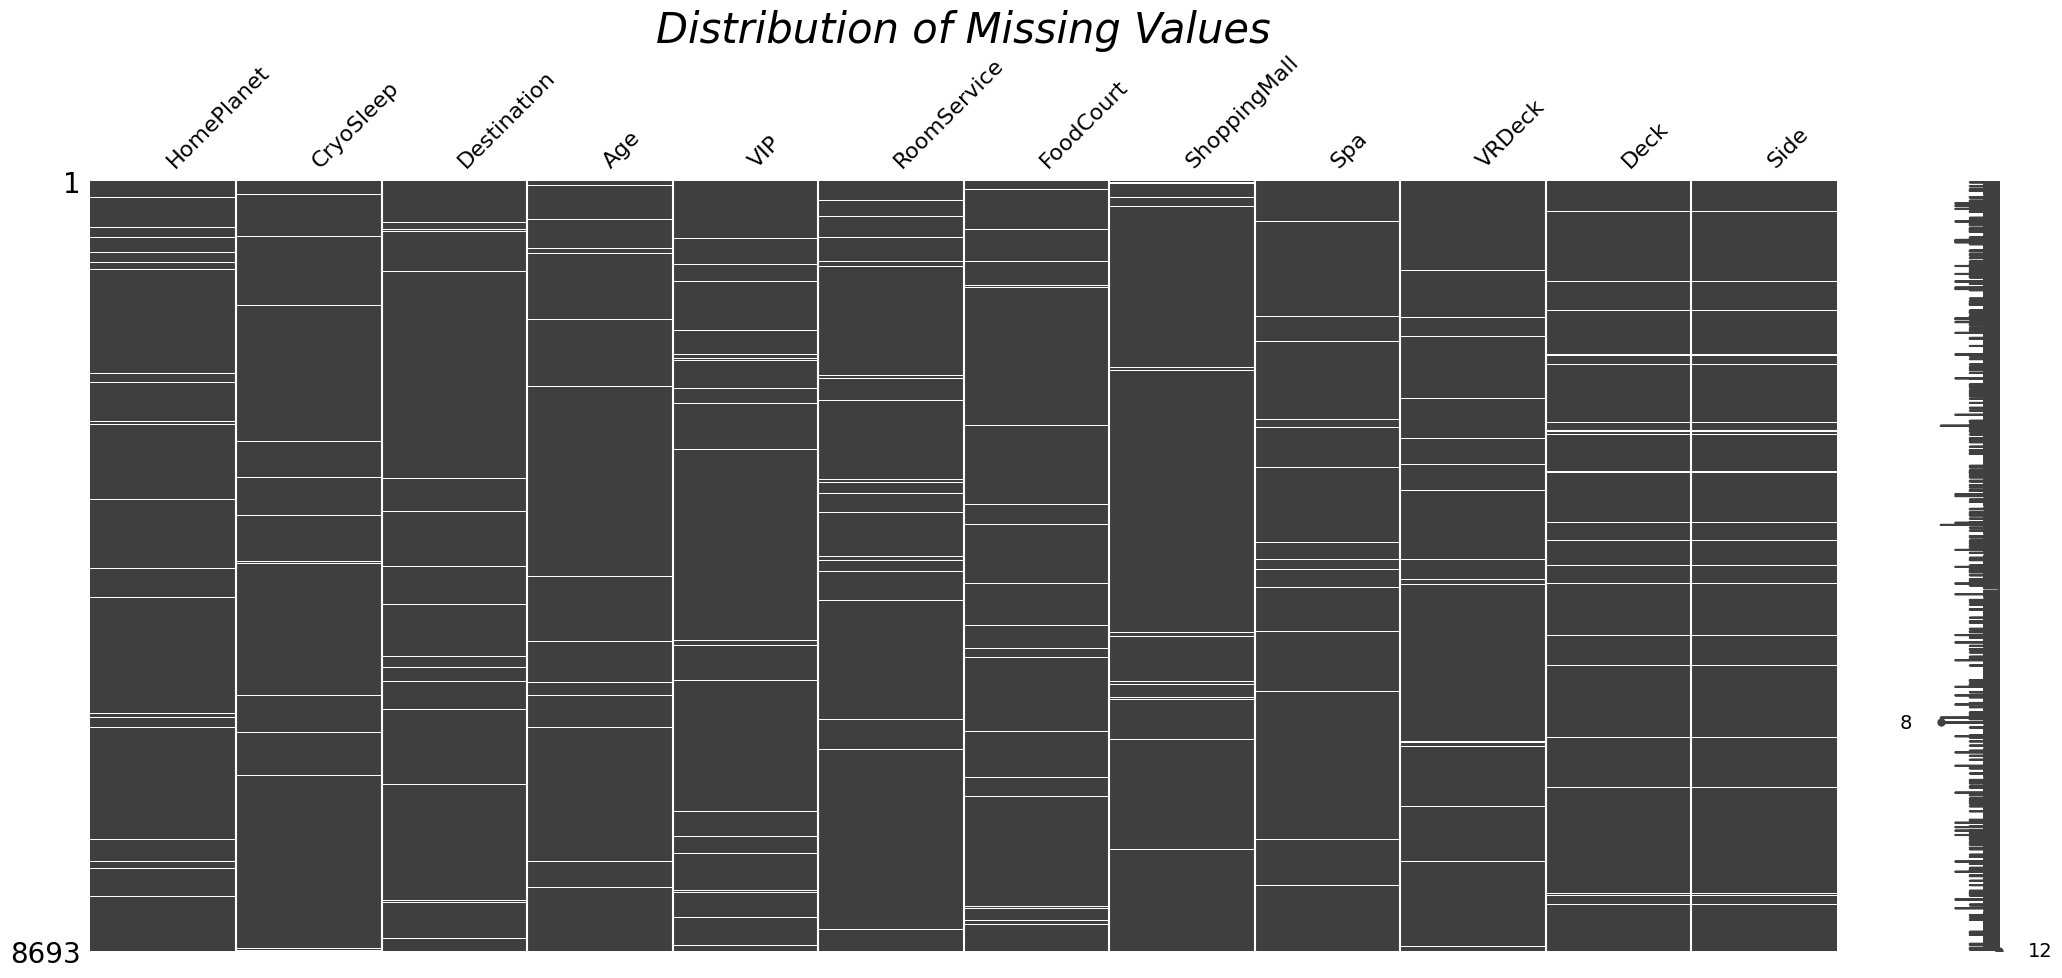

In [8]:
import missingno as msno
missing_cols= train.columns[train.isnull().any()]
msno.matrix(train[missing_cols])
plt.title('Distribution of Missing Values',fontsize=30, fontstyle= 'oblique');

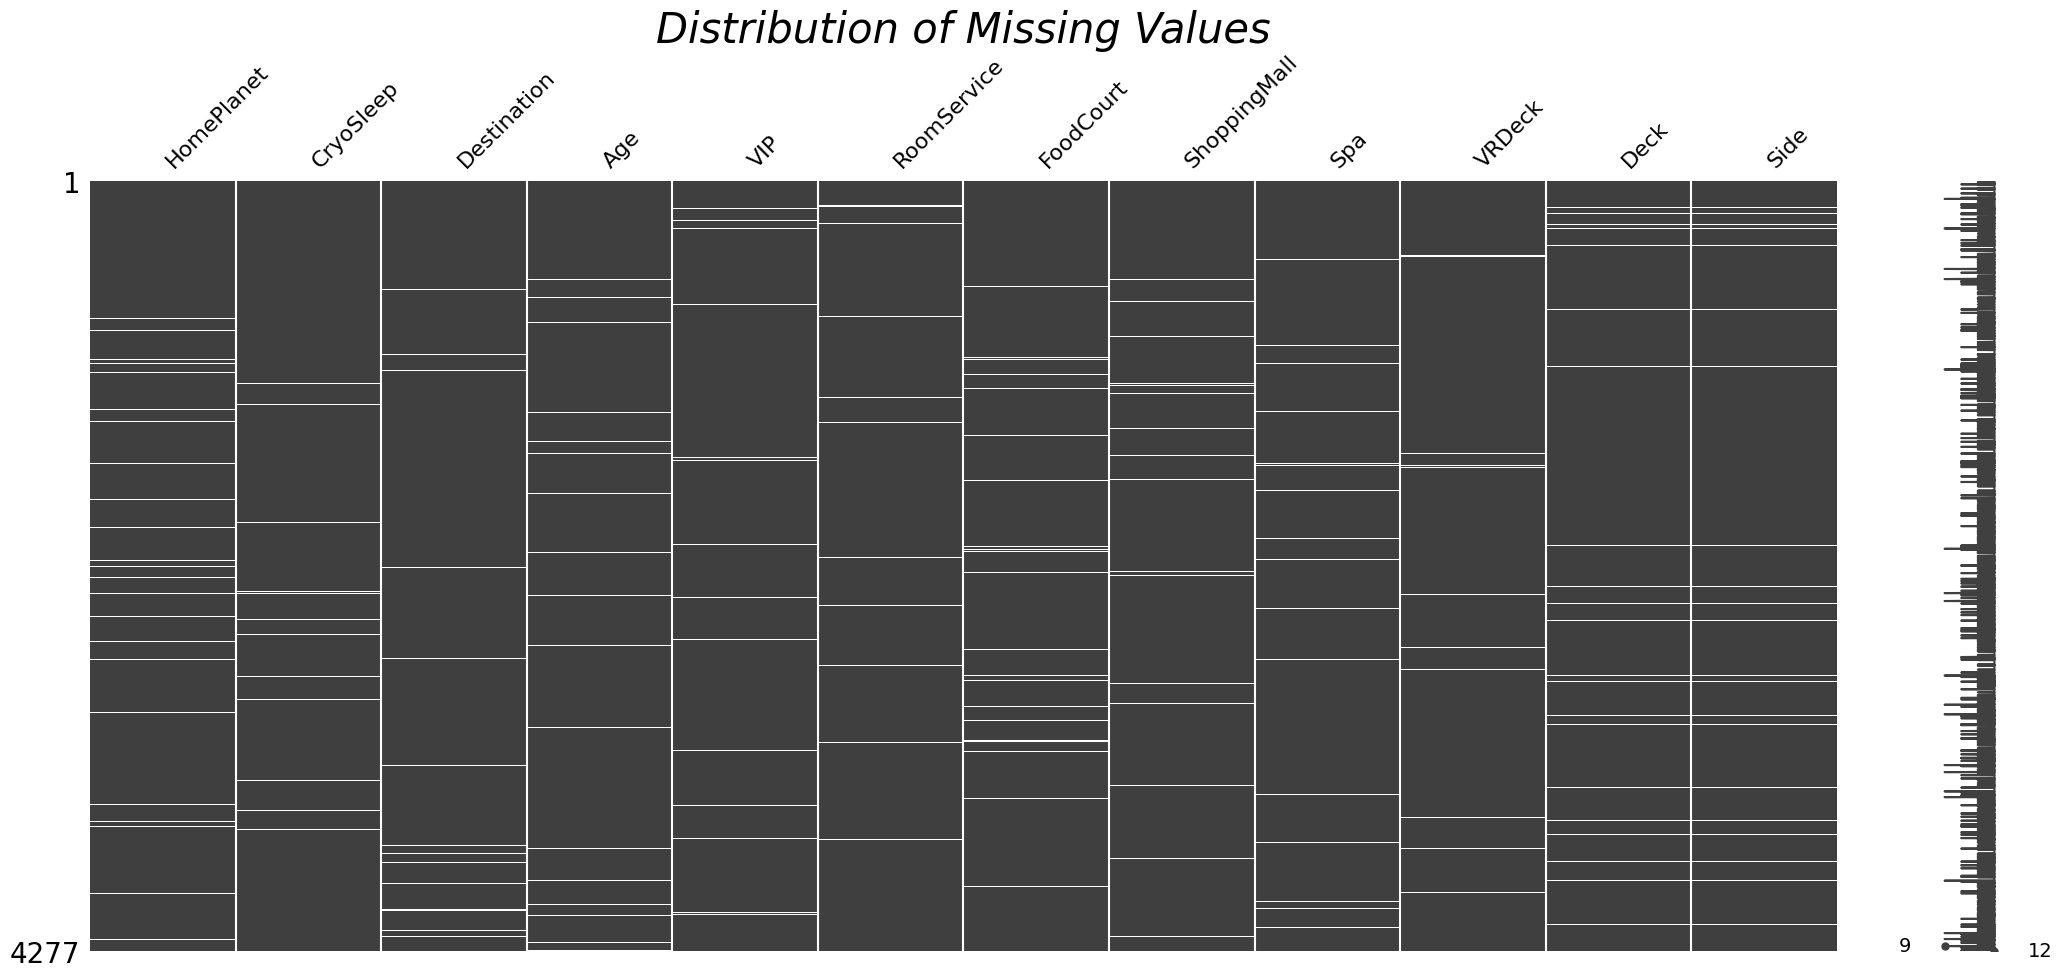

In [9]:
missing_columns= test.columns[test.isnull().any()]
msno.matrix(test[missing_columns])
plt.title('Distribution of Missing Values',fontsize=30, fontstyle= 'oblique');

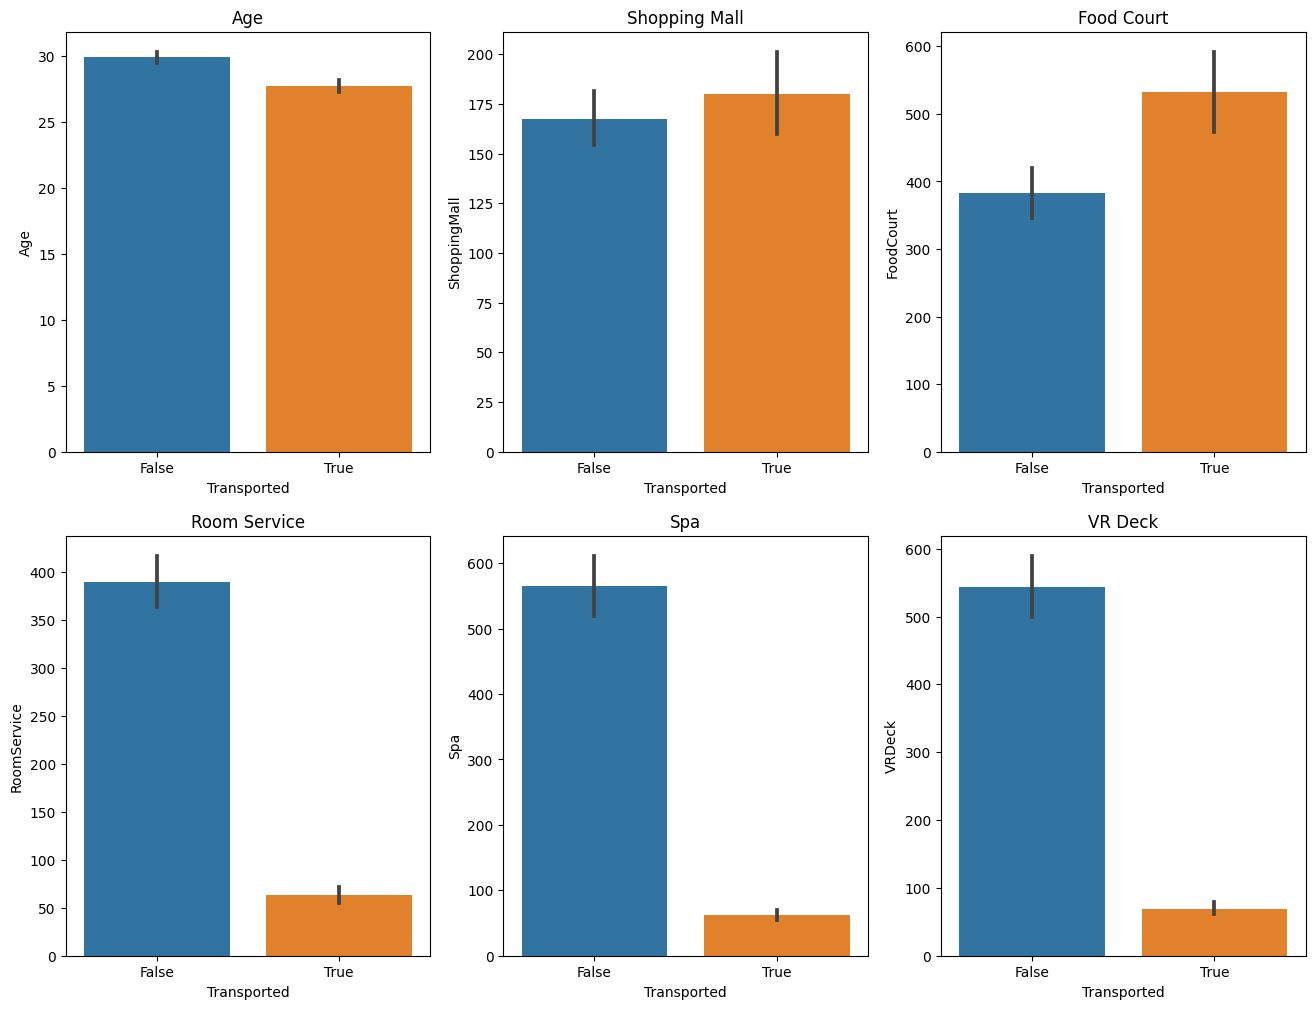

In [10]:
plt.figure(figsize = (16,12))

plt.subplot(2,3,1)
plt.title("Age")
sns.barplot(data = train, x = "Transported", y = "Age");

plt.subplot(2,3,2)
plt.title("Shopping Mall")
sns.barplot(data = train, x = "Transported", y = "ShoppingMall");

plt.subplot(2,3,3)
plt.title("Food Court")
sns.barplot(data = train, x = "Transported", y = "FoodCourt");

plt.subplot(2,3,4)
plt.title("Room Service")
sns.barplot(data = train, x = "Transported", y = "RoomService");

plt.subplot(2,3,5)
plt.title("Spa")
sns.barplot(data = train, x = "Transported", y = "Spa");

plt.subplot(2,3,6)
plt.title("VR Deck")
sns.barplot(data = train, x = "Transported", y = "VRDeck");

Insight: Age, Shopping Mall, and Food court had little to no effect. However, Room service, Spa and VR Deck had a significant effect

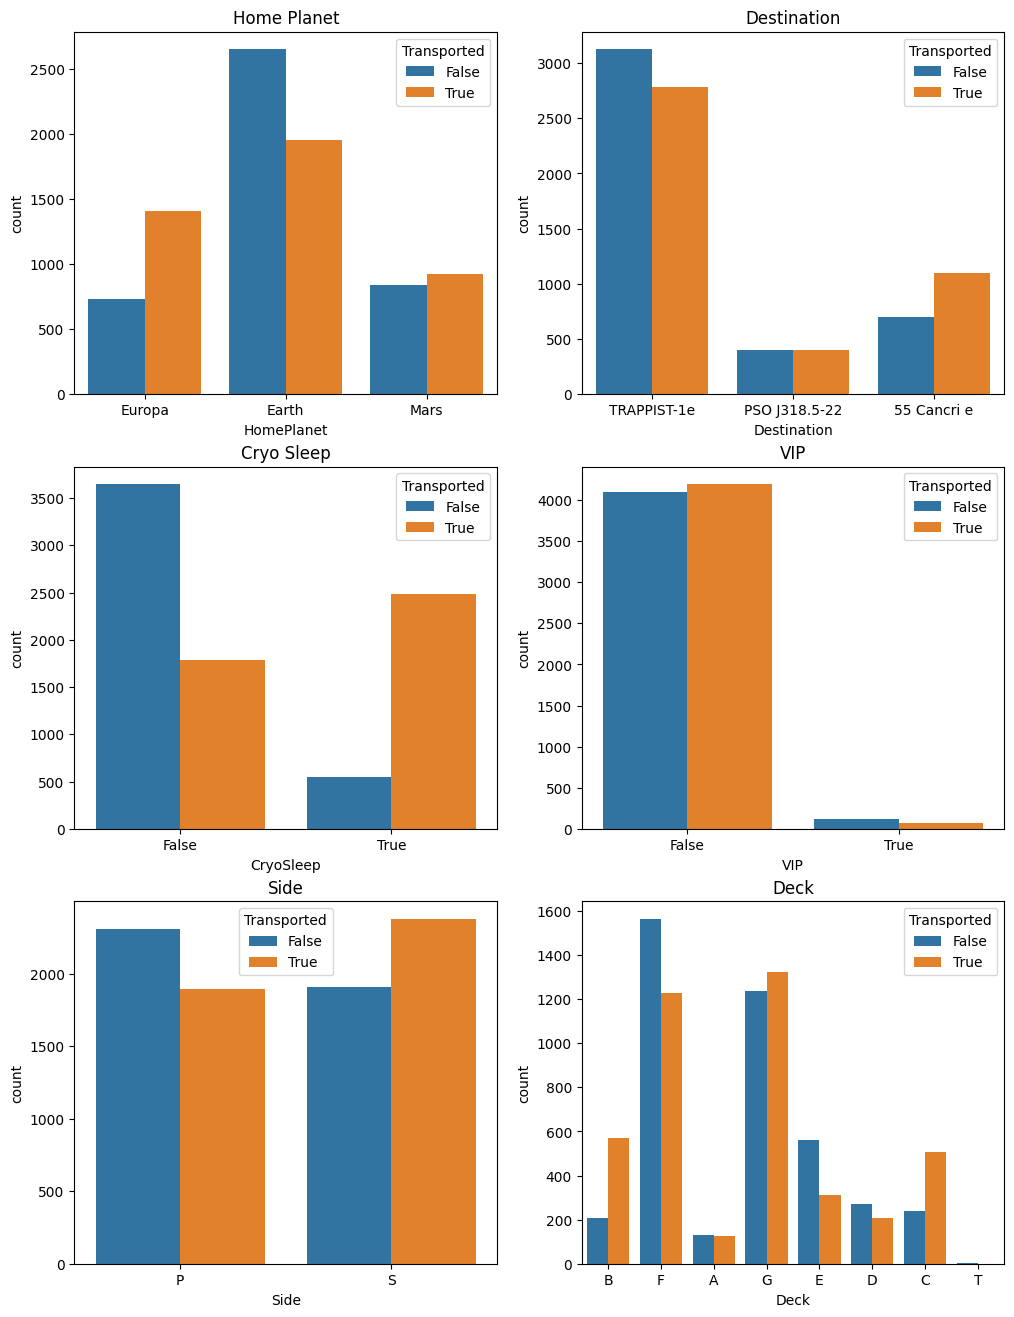

In [11]:
plt.figure(figsize = (12,16))

plt.subplot(3,2,1)
plt.title("Home Planet")
sns.countplot(data = train,x="HomePlanet", hue = "Transported");

plt.subplot(3,2,2)
plt.title("Destination")
sns.countplot(data = train,x="Destination", hue = "Transported");

plt.subplot(3,2,3)
plt.title("Cryo Sleep")
sns.countplot(data = train,x="CryoSleep", hue = "Transported");

plt.subplot(3,2,4)
plt.title("VIP")
sns.countplot(data = train,x="VIP", hue = "Transported");

plt.subplot(3,2,5)
plt.title("Side")
sns.countplot(data = train,x="Side", hue = "Transported");

plt.subplot(3,2,6)
plt.title("Deck")
sns.countplot(data = train,x="Deck", hue = "Transported");

## Feature Engineering

In [12]:
#The Data types need reformatting so that they can be preprocessed 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   bool   
 11  Deck          8494 non-null   object 
 12  Side          8494 non-null   object 
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


In [13]:
train['Transported'] = train['Transported'].astype(int)
train['CryoSleep'] = train['CryoSleep'].astype(str)
train['VIP'] = train['VIP'].astype(str)

train['Deck'] = train['Deck'].astype(str)
train['Side'] = train['Side'].astype(str)
train['CryoSleep'] = train['CryoSleep'].replace('nan', np.nan)
train['VIP'] = train['VIP'].replace('nan', np.nan)

test['CryoSleep'] = test['CryoSleep'].astype(str)
test['VIP'] = test['VIP'].astype(str)

test['Deck'] = test['Deck'].astype(str)
test['Side'] = test['Side'].astype(str)
test['CryoSleep'] = test['CryoSleep'].replace('nan', np.nan)
test['VIP'] = test['VIP'].replace('nan', np.nan)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Deck          8693 non-null   object 
 12  Side          8693 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 883.0+ KB


## Preprosessing 


In [15]:

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier

In [16]:
x_train = train.drop('Transported', axis=1)
y_train = train['Transported']
x_test = test

In [17]:
encode = make_column_transformer((OneHotEncoder(sparse_output=False),
                     x_train.select_dtypes(include='object').columns), 
                          remainder='passthrough', verbose_feature_names_out=False)

pipe = make_pipeline(encode,SimpleImputer(strategy = "most_frequent"), 
                     StandardScaler())

In [18]:
x_train = pd.DataFrame(pipe.fit_transform(x_train))
x_test = pd.DataFrame(pipe.transform(x_test))

In [19]:
x_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,-1.060617,1.754795,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,1.032865,-0.986630,-0.153063,0.715553,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003
1,0.942847,-0.569867,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,-0.329408,-0.168073,-0.275387,-0.241771,0.217158,-0.224205
2,-1.060617,1.754795,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,2.039169,-0.268001,1.959998,-0.283579,5.695623,-0.219796
3,-1.060617,1.754795,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,0.297569,-0.333105,0.523010,0.336851,2.687176,-0.092818
4,0.942847,-0.569867,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,-0.886720,0.125652,-0.237159,-0.031059,0.231374,-0.261240
5,0.942847,-0.569867,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,3.149739,-1.459188,...,-0.153063,1.032865,-0.986630,-0.153063,1.063873,-0.333105,0.021662,-0.283579,-0.012074,-0.263003
6,0.942847,-0.569867,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,-0.190079,-0.269515,0.683441,-0.278562,-0.270626,-0.263003
7,0.942847,-0.569867,-0.503664,-0.153848,-1.292858,1.364685,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,-0.050751,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003
8,0.942847,-0.569867,-0.503664,-0.153848,0.773480,-0.732770,-0.160005,-0.511013,-0.317487,0.685313,...,-0.153063,-0.968181,1.013551,-0.153063,0.436897,-0.333105,0.210921,-0.255149,-0.078711,-0.263003
9,-1.060617,1.754795,-0.503664,-0.153848,-1.292858,1.364685,-0.160005,1.956897,-0.317487,-1.459188,...,-0.153063,1.032865,-0.986630,-0.153063,-1.026048,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003


## Model the Data

In [20]:
# xgb = XGBClassifier(random_state=7)
#params = {'n_estimators': [500, 750, 1000, 1500],
#          'max_depth': [2, 4, 6, 8],
#           'learning_rate': [0.01, 0.05, 0.1],
#          'colsample_bytree': [0.3, 0.5, 0.7]}
#search = GridSearchCV(xgb, params)
#search.fit(x_train, y_train)
#search.best_params_

In [21]:
xgb = XGBClassifier(n_estimators=1000, max_depth=4, learning_rate=0.05, colsample_bytree=0.7, random_state=7);
xgb.fit(x_train, y_train);

### Prediction

In [22]:
y_pred = xgb.predict(x_test)
y_pred = y_pred.astype(bool)

### Submission

In [23]:
submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')
submission['Transported'] = y_pred
submission.to_csv('/kaggle/working/submission.csv', index=False)